# Basic Analyses:
  
To-DO: 
- decide which subjects to exclude. 

- replot the regression coefficients. 
- correlate intercept model parameters across sessions 
- read in the stai data.

In [20]:
import subprocess
label = subprocess.check_output(["git", "rev-parse","--verify","HEAD"]).strip()
print('GIT SHA: '+str(label))

GIT SHA: b'd26123c51d42279ad06c89eb8e51fba9f5a7c78f'


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
import scipy.stats as ss


/Users/chris/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import sys
sys.path.append("../functions/")
#for data preprocessing
import Scripts_Data_Processing
import imp

imp.reload(Scripts_Data_Processing)
from Scripts_Data_Processing import *
#for model fit
import Scripts_LogRegModels_v2
imp.reload(Scripts_LogRegModels_v2)
from Scripts_LogRegModels_v2 import *

import NoBrainer_Analysis_AllinOne
imp.reload( NoBrainer_Analysis_AllinOne)
from  NoBrainer_Analysis_AllinOne import *

import Correlation_bw_triplets
imp.reload( Correlation_bw_triplets)
from  Correlation_bw_triplets import *

# read in data + nobrainer

## gainloss

In [4]:
df_list = []
vp_perform_gainloss_list = []
vp_nb_gainloss_list = []
vp_list = ['06', '07', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '22', '23_2', '25_2', '26_2', '27_2', '28_2', '29', '30']
for vp in vp_list:
    path = os.path.join(os.getcwd(),'..','data','data_gainloss_logfiles','vp' + vp + '_gainloss_processed.csv')
    df = pd.read_csv(path, sep=",")
    #preprocess gainloss data
    df=preprocess_gainloss(df)
    #preprocess data
    df = preprocess(df)
    #store prepocessed data in list that contains data for all subjects (for later analysis)
    df_list.append(df)
    #create subset with unambiguous trials for no brainer analysis
    nb_df = drop_ambi_trials(df)
    #create variables indicating whether left or right was the better option
    better_choice_gainloss(nb_df)
    #indicate whether the better box was chosen
    nb_df = right_choice(nb_df)
    #only keep trials that are 'no brainers'
    nb_df = keep_nobrainers(nb_df)
    #calculate performance
    vp_perform_gainloss = ['vp' + vp, vp_perf(nb_df)]
    #store each vp performance in list
    vp_perform_gainloss_list.append(vp_perform_gainloss)
    #vp performance sectionwise
    vp_nb_gainloss = nb_df.groupby('section').mean().add_prefix('gainloss_')[['gainloss_choseBetter']]
    vp_nb_gainloss['MID'] = 'vp'+ vp
    vp_nb_gainloss_list.append(vp_nb_gainloss)
    
#make dataframe for nb performance
nobrainer_gainloss = pd.DataFrame(vp_perform_gainloss_list,columns=['MID','nbperf'])

#dataframe for single subject (last one) to try out code
gainloss_ls_df = df


In [4]:
#Merge dataframe list to single dataframe. "inner": Just take columns which exist in all dataframes    
gainloss_df = pd.concat(df_list, ignore_index = True, join = 'inner')  

## shock

In [5]:
df_list = []
vp_list = ['06', '07', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '22', '23', '25', '26', '27', '28', '29', '30']
vp_perform_shock_list = []
vp_nb_shock_list = []
section_list = ['1', '2', '3']
for vp in vp_list:
    df = []
    for sec in section_list:
        path = os.path.join(os.getcwd(),'..','data','data_shock_logfiles','Expt1Pain_Behaviour_vp' + vp + '_' + sec + '.txt')
        df_dummy = pd.read_csv(path, sep="\t", skiprows = [0])
        df_dummy = df_dummy[:-1] #deletes last row of each section as it does not contain trial data
        df_dummy['MID'] = 'vp'+ vp
        df_dummy['section'] = sec
        df_dummy.columns = df_dummy.columns.str.replace(' ','')
        df.append(df_dummy)
    
    #create a df that contains data from all sections    
    df = pd.concat(df, ignore_index = True, join = 'inner')
    #preprocess shock data
    df = preprocess_shock(df)
    #preprocess data
    df = preprocess(df)
    #store prepocessed data in list that contains data for all subjects (for later analysis)
    df_list.append(df)
    #create subset with unambiguous trials for no brainer analysis
    nb_df = drop_ambi_trials(df)
    #create variables indicating whether left or right was the better option
    better_choice_shock(nb_df)
    #indicate whether the better box was chosen
    nb_df = right_choice(nb_df)
    #only keep trials that are 'no brainers'
    nb_df = keep_nobrainers(nb_df)
    #calculate performance
    vp_perform_shock = ['vp' + vp, vp_perf(nb_df)]
    #store each vp performance in list
    vp_perform_shock_list.append(vp_perform_shock)
    #vp performance sectionwise
    vp_nb_shock = nb_df.groupby('section').mean().add_prefix('shock_')[['shock_choseBetter']]
    vp_nb_shock['MID'] = 'vp'+ vp
    vp_nb_shock_list.append(vp_nb_shock)
    
#make dataframe for nb performance
nobrainer_shock = pd.DataFrame(vp_perform_shock_list,columns=['MID','nbperf'])

#dataframe for single subject (last one) to try out code
shock_ls_df = df

In [6]:
#create complete df for shock condition with all vps        
shock_df = pd.concat(df_list, ignore_index = True, join = 'inner')

# Model fit - individual subjects

In [7]:
param_sets_split = {}
param_sets_split['0'] = ['mag_diff','prob_diff']
param_sets_split['1'] = ['mag_diff','prob_diff','ambiguityLevel']

## gainloss

In [ ]:
model

In [ ]:
vp_list = ['06','07','10','11', '12', '13', '15', '16', '17', '18', '19', '20', '22', '23_2', '25_2', '26_2', '27_2', '28_2', '29', '30']
resultnames = ['bic','aic','pseudoR2','pred_acc', 'llr_pvalue']
model_param_df = np.array(['','','',3.0,3.0])
model_summary_df = nobrainer_gainloss

for vp in vp_list:
    
    df = gainloss_df[gainloss_df.MID == 'vp' + vp]
    MID = 'vp' + vp
        
    for split in ['ambig_gain','ambig_loss','unambig_gain','unambig_loss']:
        if 'unambig' in split:
            paramnum='0'
        else:
            paramnum='1'
            
        # Fit a model to each set of trials 
        out = fit_model_split_amb_unamb_gain_loss(df, whichreturn= split, params=param_sets_split[paramnum],zscore=True)
        
        modelname = out['modelname']

        for result in resultnames:
            model_summary_df.loc[(model_summary_df.MID== 'vp' + vp),result+'_'+split]=out[result]

        params = out['params']
        se=out['se']
        for param in params.index:
            paramn = param.replace('_loss','')
            paramn = paramn.replace('_gain','')
            paramn = paramn.replace('_amb','')
            paramn = paramn.replace('_rl','')
            row = np.array([MID,paramn,split,params[param],se[param]])
            model_param_df=np.vstack((model_param_df,row))

model_param_df = pd.DataFrame(model_param_df,columns=['MID','parameter','split','beta','se'])
model_param_df.drop(0,inplace=True) #df.index[0]
model_param_df['beta']=model_param_df['beta'].astype('float')
model_param_df_gainloss = model_param_df
model_summary_gainloss_df = model_summary_df



In [9]:
#print(out['aic'])
#print(out['pred_acc'])
#print(out['modelname'])
#out['results'].summary()



## shock

In [10]:
vp_list = ['06', '07', '10', '11' ,'12', '13', '15', '16', '17', '18', '19', '20', '22', '23', '25', '26', '27', '28', '29', '30']
resultnames = ['bic','aic','pseudoR2','pred_acc', 'llr_pvalue'] 
model_param_df = np.array(['','','',3.0, 3.0])
model_summary_df = nobrainer_shock

for vp in vp_list:
    
    df = shock_df[shock_df.MID == 'vp' + vp]
    MID = 'vp' + vp
        
    for split in ['ambig_shock','unambig_shock']:
        #print(split)
        if 'unambig' in split:
            paramnum='0'
        else:
            paramnum='1'
        # Fit a model to the ambiguous gain trials 
        out = fit_model_split_amb_unamb_gain_loss(df, whichreturn= split, params=param_sets_split[paramnum],zscore=True)
        
    
        modelname = out['modelname']

        for result in resultnames:
            model_summary_df.loc[(model_summary_df.MID== 'vp' + vp),result+'_'+split]=out[result]

        params = out['params']
        se = out['se']
        for param in params.index:
            paramn = param.replace('_gain','')
            paramn = paramn.replace('_amb','')
            paramn = paramn.replace('_rl','')
            row = np.array([MID,paramn,split,params[param],se[param]])
            model_param_df=np.vstack((model_param_df,row))

model_param_df = pd.DataFrame(model_param_df,columns=['MID','parameter','split','beta', 'se'])
model_param_df.drop(0,inplace=True) #df.index[0]
model_param_df['beta']=model_param_df['beta'].astype('float')
model_param_df_shock = model_param_df        
model_summary_shock_df = model_summary_df
   

### scatterplots for model fit and significance

#### gainloss

C:\Users\Hanna\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


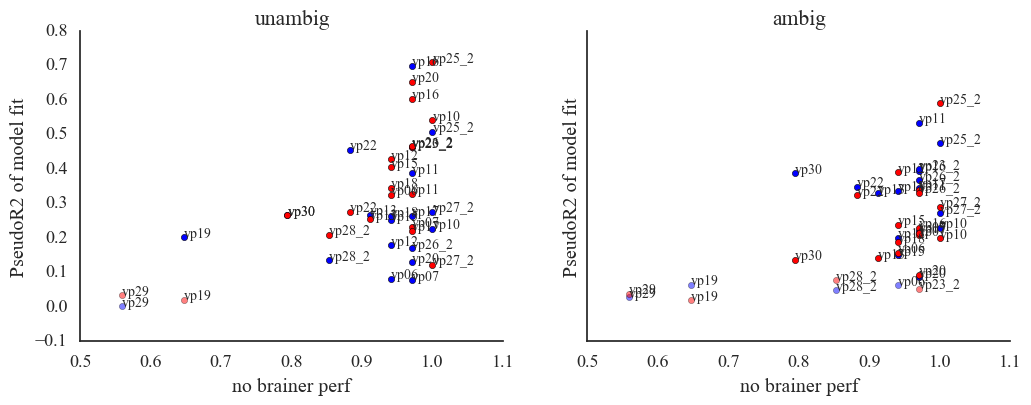

In [11]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
matplotlib.rc("font", family="Times New Roman")
sns.set_context('talk')
fig,axes =plt.subplots(1,2, figsize=(12,4),sharey=True,sharex=True)

MIDS = model_summary_gainloss_df.MID
NB = model_summary_gainloss_df['nbperf']
for tt,trial_type in enumerate(['unambig','ambig']):
    for task in ['gain','loss']:
        R2 = model_summary_gainloss_df['pseudoR2_'+trial_type+'_'+task]
        pvals = model_summary_gainloss_df['llr_pvalue_'+trial_type+'_'+task]
        color ='b' if task=='gain' else 'r'
        plt.legend()

        for r,n,p,mid in zip(R2,NB,pvals,MIDS):
            alpha=1.0 if p<0.05 else 0.5
            axes[tt].scatter(n,r, c=color,alpha=alpha)
            axes[tt].annotate(mid,(n,r),fontsize=10)
            #plt.legend()
    axes[tt].set_xlabel('no brainer perf')
    axes[tt].set_ylabel('PseudoR2 of model fit')
    axes[tt].set_title(trial_type)

sns.despine()
#plt.legend()



#### shock

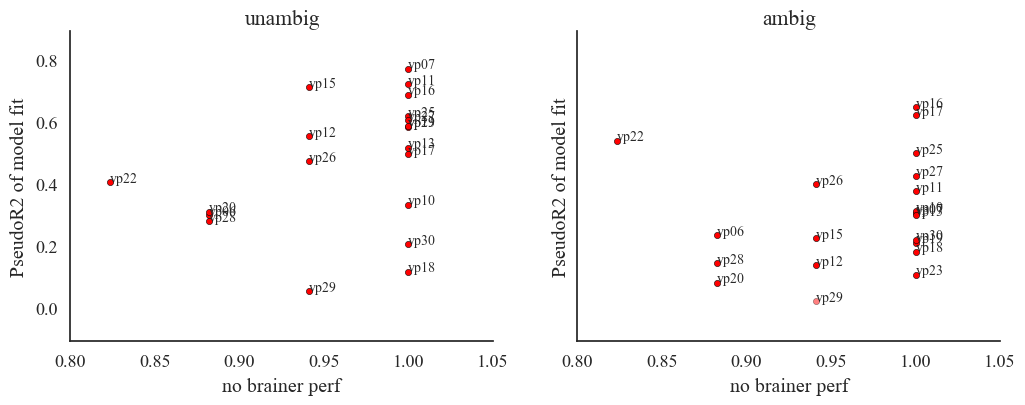

In [12]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
matplotlib.rc("font", family="Times New Roman")
sns.set_context('talk')
fig,axes =plt.subplots(1,2, figsize=(12,4),sharey=True,sharex=True)

MIDS = model_summary_shock_df.MID
NB = model_summary_shock_df['nbperf']
for tt,trial_type in enumerate(['unambig','ambig']):
    for task in ['shock']:
        R2 = model_summary_shock_df['pseudoR2_'+trial_type+'_'+task]
        pvals = model_summary_shock_df['llr_pvalue_'+trial_type+'_'+task]
        color ='b' if task=='gain' else 'r'

        for r,n,p,mid in zip(R2,NB,pvals,MIDS):
            alpha=1.0 if p<0.05 else 0.5
            axes[tt].scatter(n,r, c=color,alpha=alpha)
            axes[tt].annotate(mid,(n,r),fontsize=10)
    axes[tt].set_xlabel('no brainer perf')
    axes[tt].set_ylabel('PseudoR2 of model fit')
    axes[tt].set_title(trial_type)
sns.despine()
plt.legend()

- what the hell is going on with the subjects that have .95 no brainer and <0.1 R2. 


### bargraph for parameters

In [13]:
# dataframe for gainloss and shock to plot in one graph
model_param_df = pd.concat([model_param_df_gainloss, model_param_df_shock])

In [14]:
# reverse beta parameters for shock and loss to match gain
model_param_df.loc[(model_param_df.split == 'ambig_shock') & (model_param_df.parameter == 'mag_diff'), 'beta'] = model_param_df.loc[(model_param_df.split == 'ambig_shock')& (model_param_df.parameter == 'mag_diff'),'beta']*-1
model_param_df.loc[(model_param_df.split == 'unambig_shock') & (model_param_df.parameter == 'mag_diff'), 'beta'] = model_param_df.loc[(model_param_df.split == 'unambig_shock') & (model_param_df.parameter == 'mag_diff'),'beta']*-1

model_param_df.loc[(model_param_df.split == 'ambig_shock') & (model_param_df.parameter == 'prob_diff'), 'beta'] = model_param_df.loc[(model_param_df.split == 'ambig_shock') & (model_param_df.parameter == 'prob_diff'),'beta']*-1
model_param_df.loc[(model_param_df.split == 'unambig_shock') & (model_param_df.parameter == 'prob_diff'), 'beta'] = model_param_df.loc[(model_param_df.split == 'unambig_shock') & (model_param_df.parameter == 'prob_diff'),'beta']*-1
model_param_df.loc[(model_param_df.split == 'ambig_loss') & (model_param_df.parameter == 'prob_diff'), 'beta'] = model_param_df.loc[(model_param_df.split == 'ambig_loss') & (model_param_df.parameter == 'prob_diff'),'beta']*-1
model_param_df.loc[(model_param_df.split == 'unambig_loss') & (model_param_df.parameter == 'prob_diff'), 'beta'] = model_param_df.loc[(model_param_df.split == 'unambig_loss') & (model_param_df.parameter == 'prob_diff'),'beta']*-1


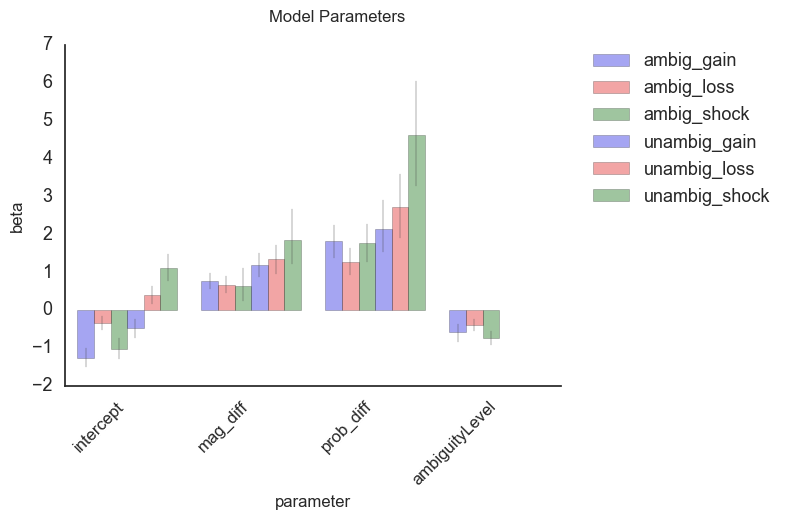

In [15]:
#plot bargraph
fig = plot_params(model_param_df, stripplot=False)

- remove bad fitting subjects - vp19 and vp29

In [16]:
print(len(model_param_df_shock))
model_param_df_shock = model_param_df_shock.loc[model_param_df_shock['MID']!='vp29',]
model_param_df_shock = model_param_df_shock.loc[model_param_df_shock['MID']!='vp19',]
print(len(model_param_df_shock))

140
126


In [17]:
print(len(model_param_df_gainloss))
model_param_df_gainloss = model_param_df_gainloss.loc[model_param_df_gainloss['MID']!='vp29',]
model_param_df_gainloss = model_param_df_gainloss.loc[model_param_df_gainloss['MID']!='vp19',]
print(len(model_param_df_gainloss))

280
252


In [18]:
print(len(model_param_df))
model_param_df = model_param_df.loc[model_param_df['MID']!='vp29',]
model_param_df = model_param_df.loc[model_param_df['MID']!='vp19',]
print(len(model_param_df))

420
378


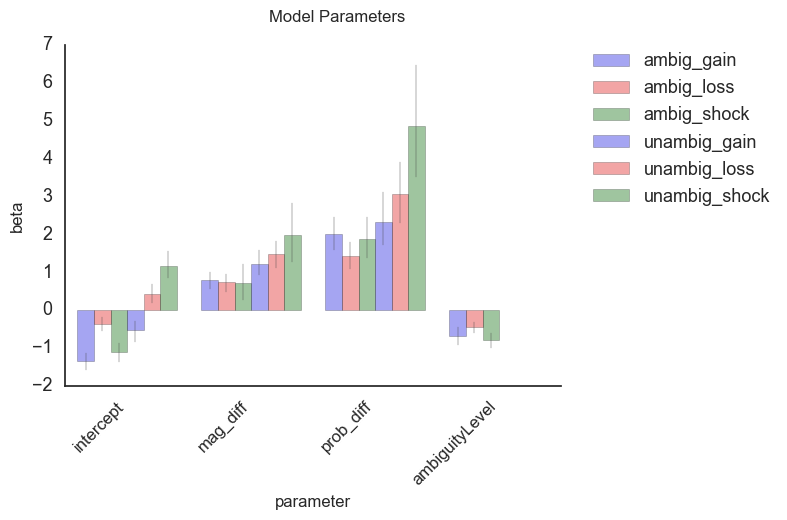

In [19]:
#bargraph without excluded subjects
fig = plot_params(model_param_df, stripplot=False)

# Plot individual parameter per task
- add x axis labels

In [20]:
#change MIDs to match between gainloss and shock versions
model_param_df.MID = model_param_df.MID.apply(lambda x: x.replace('_2', ''))

In [6]:
sns.set(style="ticks")
#model_param_df_merged = sns.load_dataset("model_param_df_merged")
#g = sns.factorplot(x="split", y="beta", col="parameter", row="MID", data=model_param_df)

# Triplet dataframe

## ambiguous trials

In [22]:
triplet_intercept = triplet(model_param_df, 'intercept', ambiguous=True)
triplet_magdiff = triplet(model_param_df, 'mag_diff', ambiguous=True)
triplet_probdiff = triplet(model_param_df, 'prob_diff', ambiguous=True)
triplet_ambiguityLevel = triplet(model_param_df, 'ambiguityLevel', ambiguous=True)

## unambiguous trials
- needs to be adjusted/completed in .py file

In [23]:
triplet_intercept_unambi = triplet(model_param_df, 'intercept', ambiguous=False)
triplet_magdiff_unambi = triplet(model_param_df, 'mag_diff', ambiguous=False)
triplet_probdiff_unambi = triplet(model_param_df, 'prob_diff', ambiguous=False)
triplet_ambiguityLevel_unambi = triplet(model_param_df, 'ambiguityLevel', ambiguous=False)

In [24]:
## for anovas
#triplet_intercept['parameter'] = 'intercept'
#triplet_intercept['ambiguity'] = 'ambi'
#triplet_magdiff['parameter'] = 'magdiff'
#triplet_magdiff['ambiguity'] = 'ambi'
#triplet_probdiff['parameter'] = 'probdiff'
#triplet_probdiff['ambiguity'] = 'ambi'
#triplet_ambiguityLevel['parameter'] = 'ambiguityLevel'
#triplet_ambiguityLevel['ambiguity'] = 'ambi'

In [25]:
#triplet_intercept_unambi['parameter'] = 'intercept'
#triplet_intercept_unambi['ambiguity'] = 'unambi'
#triplet_magdiff_unambi['parameter'] = 'magdiff'
#triplet_magdiff_unambi['ambiguity'] = 'unambi'
#triplet_probdiff_unambi['parameter'] = 'probdiff'
#triplet_probdiff_unambi['ambiguity'] = 'unambi'
#triplet_ambiguityLevel_unambi['parameter'] = 'ambiguityLevel'
#triplet_ambiguityLevel_unambi['ambiguity'] = 'unambi'

In [26]:
#triplet = triplet_intercept.append(triplet_intercept_unambi)
#df_list = triplet_magdiff, triplet_magdiff_unambi, triplet_probdiff, triplet_probdiff_unambi, triplet_ambiguityLevel, triplet_ambiguityLevel_unambi

#for x in df_list:

 #   triplet = triplet.append(x)

In [27]:
#triplet = triplet.append(triplet_ambiguityLevel_unambi)

In [28]:
#path = 'C:\\Users\\Hanna'

#triplet.to_csv('triplet.csv', sep=',')

In [29]:
#triplet_ambiguityLevel_unambi

In [30]:
#triplet_intercept.head()


# subject count per order of task
-function need to go to a .py file

In [31]:
def count_order(triplet_df):

    triplet_df['order'] = np.nan

    triplet_df.loc[(triplet_df['gain'] > triplet_df['loss']) & (triplet_df['loss'] > triplet_df['shock']) & (triplet_df['gain'] > triplet_df['shock']), 'order'] = 'gls'

    triplet_df.loc[(triplet_df['gain'] > triplet_df['loss']) & (triplet_df['loss'] < triplet_df['shock']) & (triplet_df['gain'] > triplet_df['shock']), 'order'] = 'gsl'

    triplet_df.loc[(triplet_df['loss'] > triplet_df['gain']) & (triplet_df['gain'] > triplet_df['shock']) & (triplet_df['loss'] > triplet_df['shock']), 'order'] = 'lgs'

    triplet_df.loc[(triplet_df['loss'] > triplet_df['gain']) & (triplet_df['gain'] < triplet_df['shock']) & (triplet_df['loss'] > triplet_df['shock']), 'order'] = 'lsg'

    triplet_df.loc[(triplet_df['shock'] > triplet_df['gain']) & (triplet_df['gain'] > triplet_df['loss']) & (triplet_df['loss'] < triplet_df['shock']), 'order'] = 'sgl'

    triplet_df.loc[(triplet_df['shock'] > triplet_df['gain']) & (triplet_df['gain'] < triplet_df['loss']) & (triplet_df['loss'] < triplet_df['shock']), 'order'] = 'slg'

    orderCount = pd.value_counts(triplet_df['order'])
    
    return(orderCount)

In [32]:
count_order(triplet_intercept)

lsg    10
lgs     7
slg     1
Name: order, dtype: int64

In [33]:
count_order(triplet_probdiff)

sgl    7
gls    5
gsl    3
lgs    2
slg    1
Name: order, dtype: int64

In [34]:
count_order(triplet_magdiff)

gls    7
lsg    3
sgl    2
lgs    2
slg    2
gsl    2
Name: order, dtype: int64

In [35]:
count_order(triplet_ambiguityLevel)

gls    6
lsg    5
lgs    3
gsl    2
slg    1
sgl    1
Name: order, dtype: int64

In [36]:
triplet_probdiff.head()

,MID,gain,se_gain,loss,se_loss,shock,se_shock,order
0,vp06,0.618895,0.39654069989,0.171944,0.302125573416,1.654646,0.424077566921,sgl
1,vp07,1.156406,0.40292163675,1.251173,0.389190478561,1.871591,0.478225225102,slg
2,vp10,1.631189,0.447625740324,1.461982,0.403165070184,1.241292,0.429255250639,gls
3,vp11,4.201267,1.09595628298,2.184089,0.512258574857,2.164188,0.524700221893,gls
4,vp12,1.411448,0.427845850988,2.093028,0.496851595753,0.877154,0.35425932307,lgs


In [37]:
tableOrder = triplet_intercept.drop(triplet_intercept.columns[[1, 2, 3, 4, 5, 6]], axis=1)  # df.columns is zero-based pd.Index 


In [38]:
#table to plot counts
tableOrder = tableOrder.rename(columns={'order': 'intercept'})
tableOrder['prob_diff'] = triplet_probdiff['order']
tableOrder['mag_diff'] = triplet_magdiff['order']
tableOrder['ambiguityLevel'] = triplet_ambiguityLevel['order']
#table order should be long format
tableOrder = pd.melt(tableOrder, id_vars = 'MID', value_vars = ['intercept', 'prob_diff', 'mag_diff', 'ambiguityLevel'], var_name='parameter', value_name = 'order')

In [39]:
frame = tableOrder.groupby(['parameter', 'order'], as_index = False).count()
frame = frame.pivot(index='parameter', columns='order', values='MID')
frame = frame.fillna(0)
#frame = frame.as_matrix()
frame

order,gls,gsl,lgs,lsg,sgl,slg
parameter,,,,,,
ambiguityLevel,6.0,2.0,3.0,5.0,1.0,1.0
intercept,0.0,0.0,7.0,10.0,0.0,1.0
mag_diff,7.0,2.0,2.0,3.0,2.0,2.0
prob_diff,5.0,3.0,2.0,0.0,7.0,1.0


In [43]:
ss.chisquare(frame, f_exp=None, ddof=0, axis=1)

Power_divergenceResult(statistic=array([  7.33333333,  32.        ,   6.66666667,  11.33333333]), pvalue=array([  1.97006560e-01,   5.94126010e-06,   2.46634152e-01,
         4.51571721e-02]))

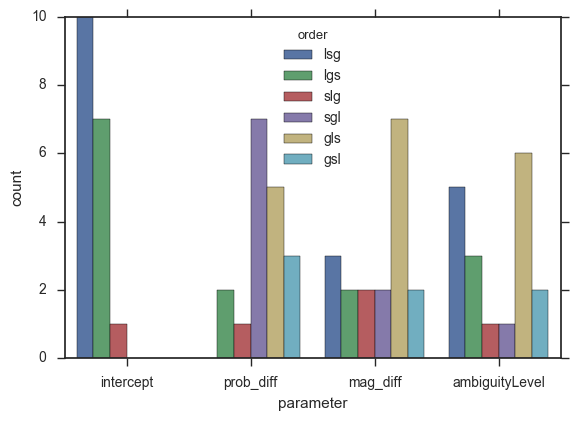

In [44]:
#plot counts
sns.countplot(x='parameter', hue='order', data=tableOrder)

# Traits (STAI)

## read in data and prepare dataframe

In [45]:
#get data
#change directory to data folder
os.chdir("../data/")
cwd = os.getcwd()
xl = pd.ExcelFile('STAI.xlsx')
STAI_df = xl.parse('Data_Collection_Log')
STAI_df = STAI_df[['Subject ID', 'Session', 'STAI']]
STAI_df.columns = STAI_df.columns.str.replace(' ','')
STAI_df = STAI_df[STAI_df.SubjectID.str.contains("pilot") == False]
STAI_df = STAI_df.loc[STAI_df['Session'] == 1, :]

In [46]:
#exclude subjects
vp_list = ['vp08', 'vp09', 'vp13' ,'vp14', 'vp21', 'vp24']

for vp in vp_list:
    
    STAI_df = STAI_df[STAI_df.SubjectID != vp]

In [47]:
#change column name of key variable to match 
STAI_df = STAI_df.rename(columns={'SubjectID': 'MID'})

In [48]:
triplet_intercept_STAI = triplet_intercept.merge(STAI_df, 'left')
triplet_probdiff_STAI = triplet_probdiff.merge(STAI_df, 'left')
triplet_magdiff_STAI = triplet_magdiff.merge(STAI_df, 'left')
triplet_ambiguityLevel_STAI = triplet_ambiguityLevel.merge(STAI_df, 'left')

## Plot STAI and Triplet (Ambiguous)

In [49]:
def plotSTAI(triplet_df, param):
    #yerr = triplet_df['se_shock']
    #xerr = triplet_df['se_gain']
    fig,axes = plt.subplots(1,3, figsize = (12, 4),sharey=True,sharex=True)
    axes[0].scatter(triplet_df['STAI'],triplet_df['gain'])
    #axes[0].errorbar(triplet_df['gain'],triplet_df['shock'], xerr=xerr, yerr=yerr)
    axes[0].axhline(y=0.000,c="blue",linewidth=0.5,zorder=0)
    axes[0].axvline(x=40.000,c="blue",linewidth=0.5,zorder=0)

    axes[0].set_xlabel('Trait Anxiety Score')
    axes[0].set_ylabel('beta')
    #axes[0].set_ylim([-3.5,3.5])
    axes[0].set_xlim([20,60])
    r,p=spearmanr(triplet_df['STAI'],triplet_df['gain'])
    axes[0].set_title('STAI/gain r={0} p={1}'.format(np.round(r,2),np.round(p,2)))
    
    #axes[0].set_aspect('equal')

    axes[1].scatter(triplet_df['STAI'],triplet_df['loss'])
    axes[1].axhline(y=0.000,c="blue",linewidth=0.5,zorder=0)
    axes[1].axvline(x=40.000,c="blue",linewidth=0.5,zorder=0)
    axes[1].set_xlabel('Trait Anxiety Score')
    axes[1].set_ylabel('beta')
    r,p=spearmanr(triplet_df['STAI'],triplet_df['loss'])
    axes[1].set_title('STAI/loss r={0} p={1}'.format(np.round(r,2),np.round(p,2)))
    #axes[1].set_aspect('equal')

    axes[2].scatter(triplet_df['STAI'],triplet_df['shock'])
    axes[2].axhline(y=0.000,c="blue",linewidth=0.5,zorder=0)
    axes[2].axvline(x=40.000,c="blue",linewidth=0.5,zorder=0)
    axes[2].set_xlabel('Trait Anxiety Score')
    axes[2].set_ylabel('beta')
    r,p=spearmanr(triplet_df['STAI'],triplet_df['shock'])
    axes[2].set_title('STAI/shock r={0} p={1}'.format(np.round(r,2),np.round(p,2)))
    #axes[2].set_aspect('equal')
    sns.despine()

    fig.suptitle(param)
    fig.subplots_adjust(top=0.77)


- why can't I set x axis limits?
- apparently it makes it so that both axes are of the same length, also true if figsize is not set

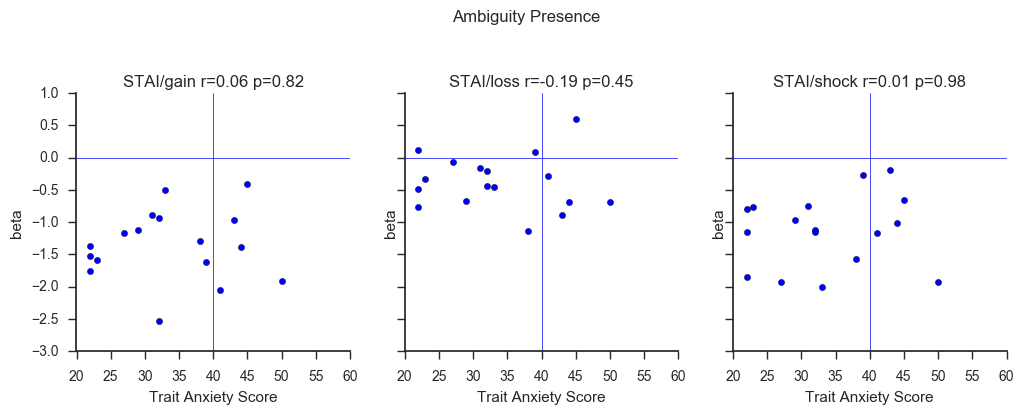

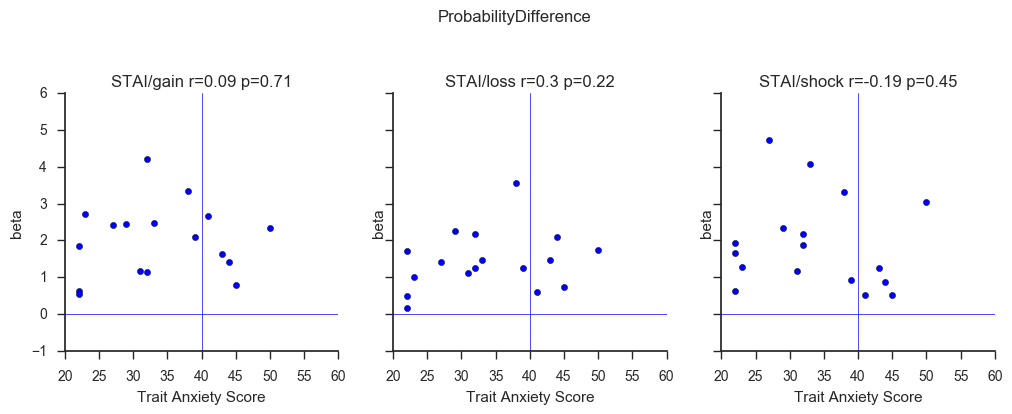

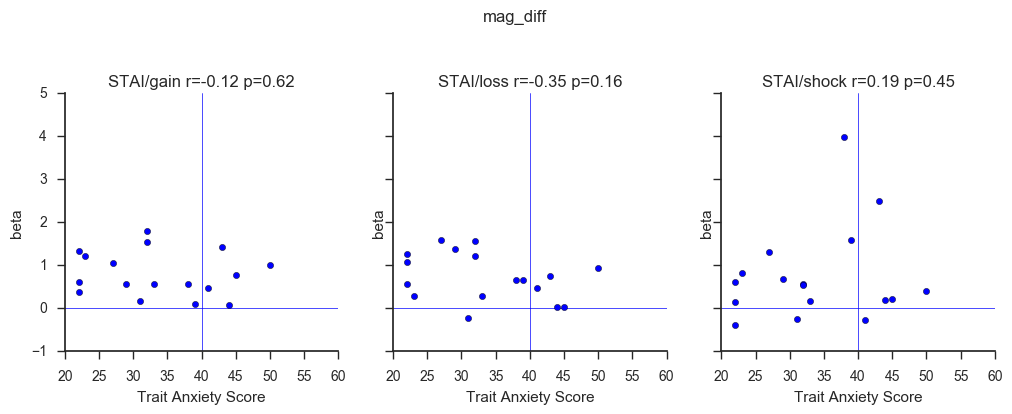

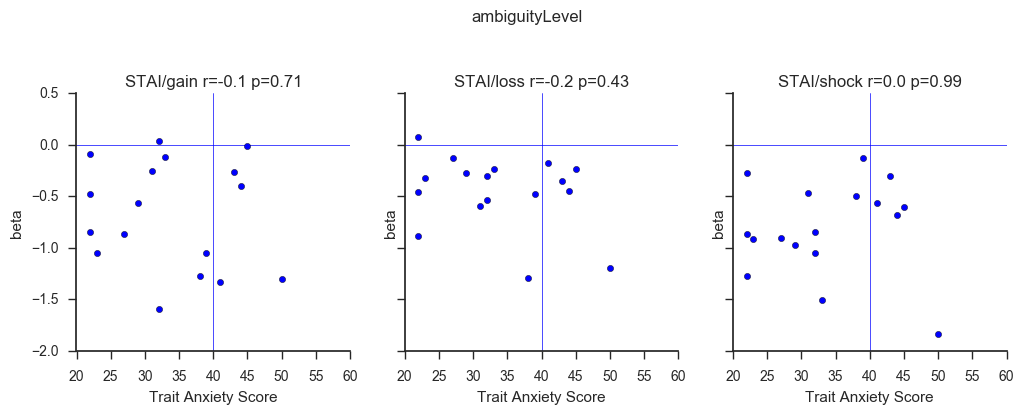

In [50]:
plotSTAI(triplet_intercept_STAI, 'Ambiguity Presence')
plotSTAI(triplet_probdiff_STAI, 'ProbabilityDifference')
plotSTAI(triplet_magdiff_STAI, 'mag_diff')
plotSTAI(triplet_ambiguityLevel_STAI, 'ambiguityLevel')

In [7]:
#triplet_probdiff_STAI

# Mean parameters per task (gain, loss, shock)

## Ambiguous Trials

### plot mean parameter per task

In [52]:
#plotTripletAllSubs(triplet_ambiguityLevel, 'ambiguityLevel')

In [ ]:
#plotTripletAllSubs(triplet_magdiff, 'mag_diff')

In [ ]:
#plotTripletAllSubs(triplet_probdiff, 'prob_diff')

In [ ]:
#plotTripletAllSubs(triplet_intercept, 'intercept')

#### plot mean parameter per task with errorbars adjusted between gain, loss, and shock

In [53]:
#adjust errorbars
def adjErrTriplet(triplet_df):
    smean = triplet_df.mean(axis=1).values
    grandMean = sum(smean)/len(smean)
    triplet_df['shock'] = triplet_df['shock']-smean+grandMean
    triplet_df['gain'] = triplet_df['gain']-smean+grandMean
    triplet_df['loss'] = triplet_df['loss']-smean+grandMean
    return (triplet_df)

<Container object of 3 artists>

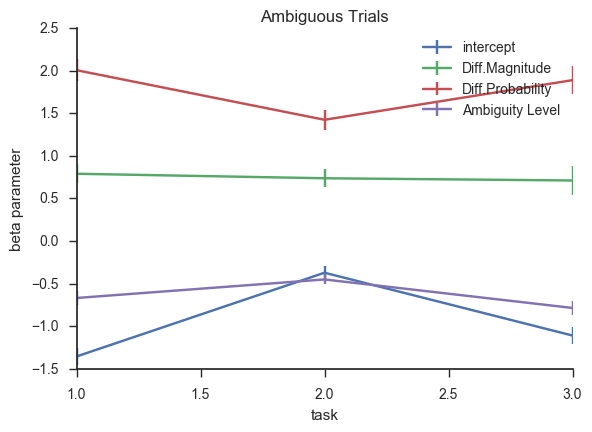

In [54]:
adjErrTriplet(triplet_intercept)
plotTripletAllSubs(triplet_intercept, 'intercept', 'Ambiguous Trials')
adjErrTriplet(triplet_magdiff)
plotTripletAllSubs(triplet_magdiff,'Diff.Magnitude','Ambiguous Trials')
adjErrTriplet(triplet_probdiff)
plotTripletAllSubs(triplet_probdiff,'Diff.Probability','Ambiguous Trials')
adjErrTriplet(triplet_ambiguityLevel)
plotTripletAllSubs(triplet_ambiguityLevel,'Ambiguity Level','Ambiguous Trials')

<Container object of 3 artists>

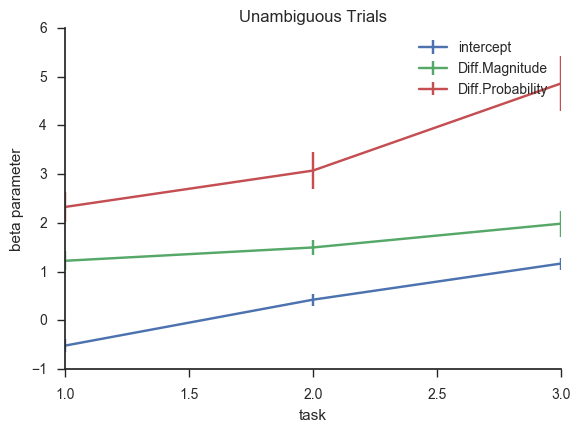

In [55]:
adjErrTriplet(triplet_intercept_unambi)
plotTripletAllSubs(triplet_intercept_unambi, 'intercept', 'Unambiguous Trials')
adjErrTriplet(triplet_magdiff_unambi)
plotTripletAllSubs(triplet_magdiff_unambi,'Diff.Magnitude','Unambiguous Trials')
adjErrTriplet(triplet_probdiff_unambi)
plotTripletAllSubs(triplet_probdiff_unambi,'Diff.Probability','Unambiguous Trials')
#adjErrTriplet(triplet_ambiguityLevel_unambi)
#plotTripletAllSubs(triplet_ambiguityLevel_unambi,'Ambiguity Level','Ambiguous Trials')

### plot scatterplot showing the spearman correlation (r and pvalue) of tasks for each parameter

### function to work on for plots (not in .py yet)
 - errorbars don't work yet. They have to be specified differently and I couldn't find out how
 - diagonal lines

##### Code snippet for trying to make errorbars work
- error message:  err must be a scalar, the same dimensions as x, or 2xN., but they are all 18
- tried within the pandas dataframe as well as as_matrix()

yerr = triplet_intercept['se_shock'].as_matrix()
xerr = triplet_intercept['se_gain'].as_matrix()
x = triplet_intercept['gain'].as_matrix()
y = triplet_intercept['shock'].as_matrix()
fig,axes = plt.subplots(1,3,figsize=(12,4),sharey=True,sharex=True)
axes[0].scatter(x,y)
axes[0].errorbar(x,y, xerr=xerr, yerr=yerr)
axes[0].axhline(y=0.000,c="blue",linewidth=0.5,zorder=0)
axes[0].axvline(x=0.000,c="blue",linewidth=0.5,zorder=0)

##### Function to modify
- add errorbars (not done)
- add horizontal and vertical lines (done)
- add diagonal lines (not done)

In [56]:
def plotTriplet(triplet_df, parameter):
    #yerr = triplet_df['se_shock'].as_matrix()
    #xerr = triplet_df['se_gain'].as_matrix()
    fig,axes = plt.subplots(1,3,figsize=(12,4),sharey=True,sharex=True)
    axes[0].scatter(triplet_df['gain'],triplet_df['shock'])
    #axes[0].errorbar(triplet_df['gain'],triplet_df['shock'], xerr=xerr, yerr=yerr)
    axes[0].axhline(y=0.000,c="blue",linewidth=0.5,zorder=0)
    axes[0].axvline(x=0.000,c="blue",linewidth=0.5,zorder=0)
    axes[0].plot([0, 1], [0, 1], transform=axes[0].transAxes, linewidth = 0.5)


    axes[0].set_xlabel('beta(gain)')
    axes[0].set_ylabel('beta(shock)')
    r,p=spearmanr(triplet_df['gain'],triplet_df['shock'])
    axes[0].set_title('gain/shock r={0} p={1}'.format(np.round(r,2),np.round(p,2)))
    axes[0].set_xlim([-4,4])
    axes[0].set_ylim([-4,4])
    axes[0].set_aspect('equal')

    axes[1].scatter(triplet_df['gain'],triplet_df['loss'])
    axes[1].axhline(y=0.000,c="blue",linewidth=0.5,zorder=0)
    axes[1].axvline(x=0.000,c="blue",linewidth=0.5,zorder=0)
    axes[1].plot([0, 1], [0, 1], transform=axes[1].transAxes, linewidth = 0.5)

    axes[1].set_xlabel('beta(gain)')
    axes[1].set_ylabel('beta(loss)')
    r,p=spearmanr(triplet_df['gain'],triplet_df['loss'])
    axes[1].set_title('gain/loss r={0} p={1}'.format(np.round(r,2),np.round(p,2)))
    axes[1].set_aspect('equal')

    axes[2].scatter(triplet_df['shock'],triplet_df['loss'])
    axes[2].axhline(y=0.000,c="blue",linewidth=0.5,zorder=0)
    axes[2].axvline(x=0.000,c="blue",linewidth=0.5,zorder=0)
    axes[2].plot([0, 1], [0, 1], transform=axes[2].transAxes, linewidth = 0.5)

    axes[2].set_xlabel('beta(shock)')
    axes[2].set_ylabel('beta(loss)')
    r,p=spearmanr(triplet_df['shock'],triplet_df['loss'])
    axes[2].set_title('shock/loss r={0} p={1}'.format(np.round(r,2),np.round(p,2)))
    axes[2].set_aspect('equal')
    sns.despine()

    fig.suptitle(parameter)
    fig.subplots_adjust(top=0.77)

    return(fig)

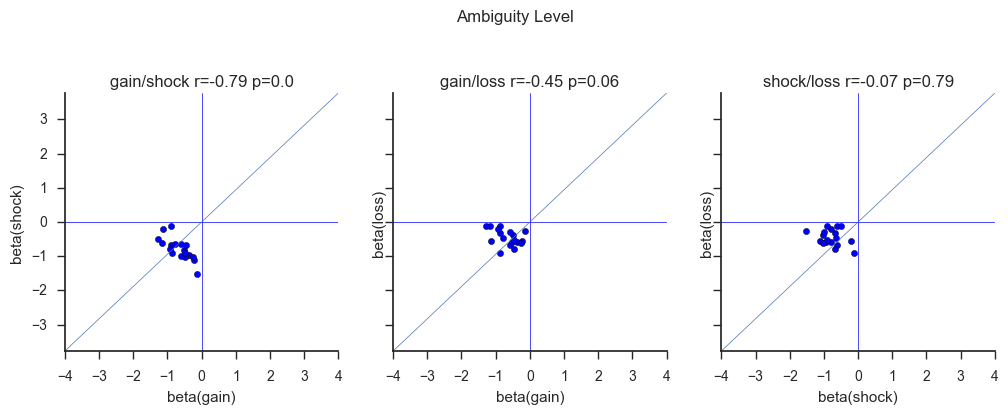

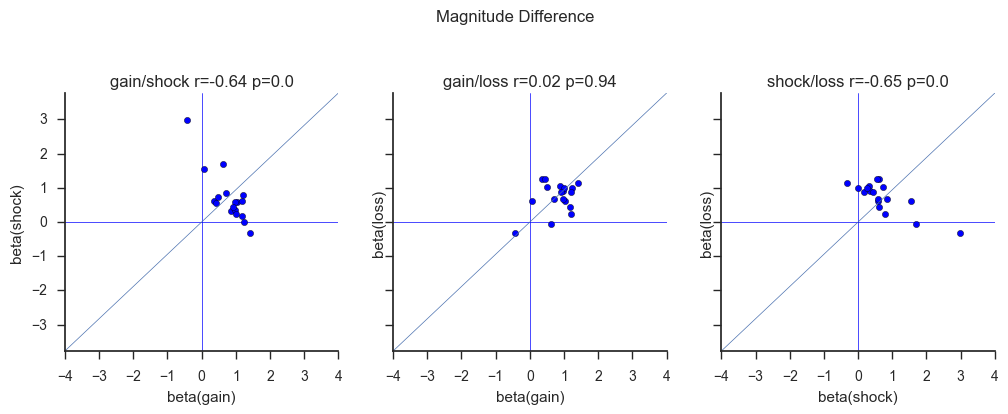

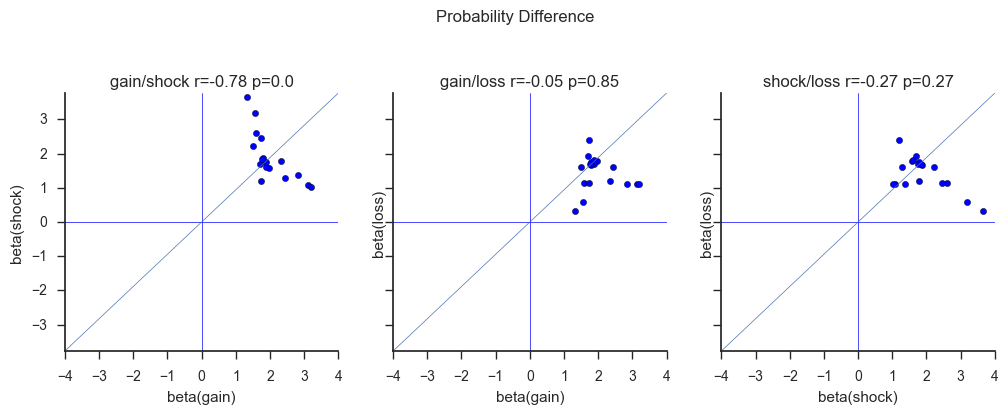

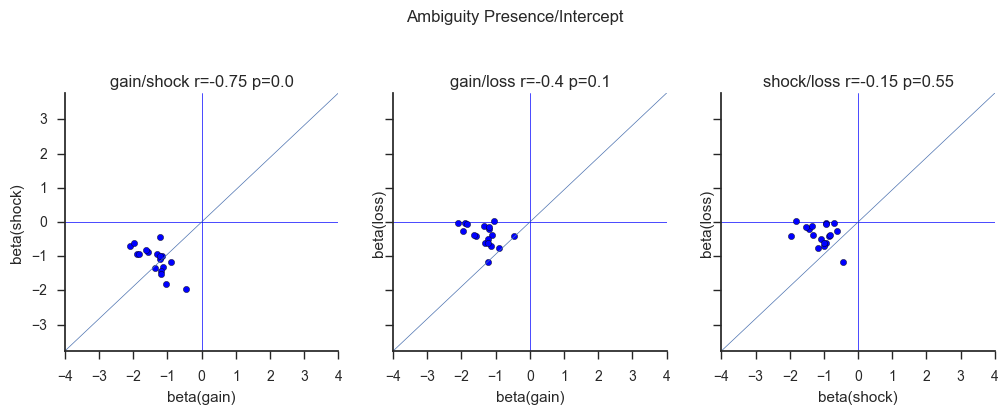

In [57]:
plotTriplet(triplet_ambiguityLevel, 'Ambiguity Level')
plotTriplet(triplet_magdiff, 'Magnitude Difference')
plotTriplet(triplet_probdiff, 'Probability Difference')
f=plotTriplet(triplet_intercept, 'Ambiguity Presence/Intercept')

#### correlation between magdiff and probdiff for every task

In [67]:
triplet_magdiff

,MID,gain,se_gain,loss,se_loss,shock,se_shock,order
0,vp06,0.366461,0.373872390106,1.270487,0.397230853501,0.602149,0.340973983094,lsg
1,vp07,1.235052,0.500751241075,1.007034,0.448858198922,-0.002988,0.350742462653,gls
2,vp10,0.616540,0.471796507085,-0.059910,0.350738826281,1.682467,0.607684259638,sgl
3,vp11,1.190468,0.570428761953,0.864671,0.455677006624,0.183958,0.361630378166,gls
4,vp12,0.714948,0.326222167367,0.677174,0.364067239233,0.846975,0.311961116926,sgl
5,vp13,0.866847,0.371510227865,1.060894,0.351103925664,0.311356,0.333461005008,lgs
6,vp15,1.026639,0.300999452458,0.618214,0.308330344047,0.594244,0.321908540456,gls
7,vp16,0.973662,0.371408478842,0.686024,0.313982927669,0.579411,0.539998302049,gls
8,vp17,0.487127,0.434771384462,1.014686,0.459401118695,0.737283,0.549959950479,lsg
9,vp18,0.062016,0.363747371708,0.620377,0.343782687546,1.556705,0.44872521146,slg


In [83]:
gain = triplet_magdiff.drop(triplet_magdiff.iloc[:, 2:8], axis = 1)
gain = gain.rename(columns={'gain': 'magdiff'})
gain['probdiff'] = triplet_probdiff['gain']


In [8]:
#gain.head()

In [96]:
loss = triplet_magdiff.drop(triplet_magdiff.iloc[:,[1,2,4,5,6,7]], axis = 1)
loss = loss.rename(columns={'loss': 'magdiff'})
loss['probdiff'] = triplet_probdiff['loss']


In [9]:
#triplet_probdiff.head()

In [10]:
#loss

In [105]:
shock = triplet_magdiff.drop(triplet_magdiff.iloc[:, [1,2,3,4,6, 7]], axis = 1)
shock = shock.rename(columns={'shock': 'magdiff'})
shock['probdiff'] = triplet_probdiff['shock']


In [13]:
#shock

In [108]:
def plotTriplet(gain, loss, shock):
    fig,axes = plt.subplots(1,3,figsize=(12,4),sharey=True,sharex=True)
    axes[0].scatter(gain['magdiff'],gain['probdiff'])
    axes[0].set_xlabel('beta(magdiff)')
    axes[0].set_ylabel('beta(probdiff)')
    r,p=spearmanr(gain['magdiff'],gain['probdiff'])
    axes[0].set_title('magdiff/probdiff r={0} p={1}'.format(np.round(r,2),np.round(p,2)))
    #axes[0].set_xlim([-4,4])
    #axes[0].set_ylim([-4,4])
    axes[0].set_aspect('equal')

    axes[1].scatter(loss['magdiff'],loss['probdiff'])
    axes[1].set_xlabel('beta(magdiff)')
    axes[1].set_ylabel('beta(probdiff)')
    r,p=spearmanr(loss['magdiff'],loss['probdiff'])
    axes[1].set_title('magdiff/loss r={0} p={1}'.format(np.round(r,2),np.round(p,2)))
    axes[1].set_aspect('equal')

    axes[2].scatter(shock['magdiff'], shock['probdiff'])
    axes[2].set_xlabel('beta(magdiff)')
    axes[2].set_ylabel('beta(probdiff)')
    r,p=spearmanr(shock['magdiff'],shock['probdiff'])
    axes[2].set_title('magdiff/probdiff r={0} p={1}'.format(np.round(r,2),np.round(p,2)))
    axes[2].set_aspect('equal')
    sns.despine()

    fig.suptitle('gain/loss/shock')
    fig.subplots_adjust(top=0.77)

    return(fig)

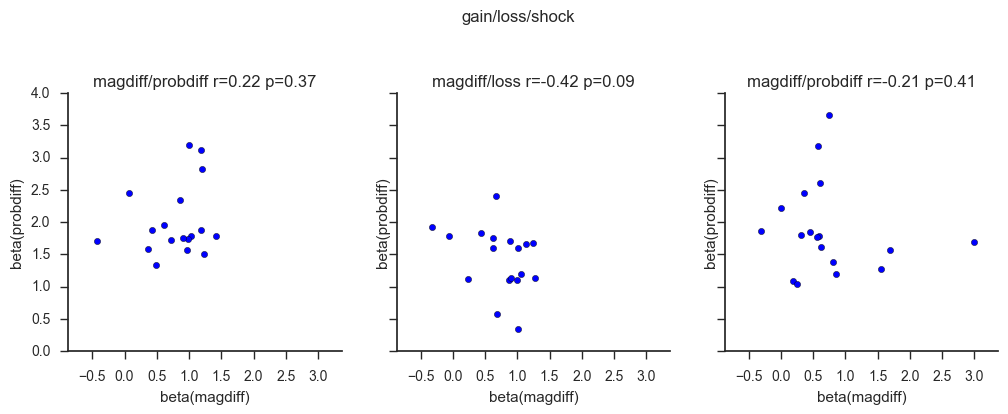

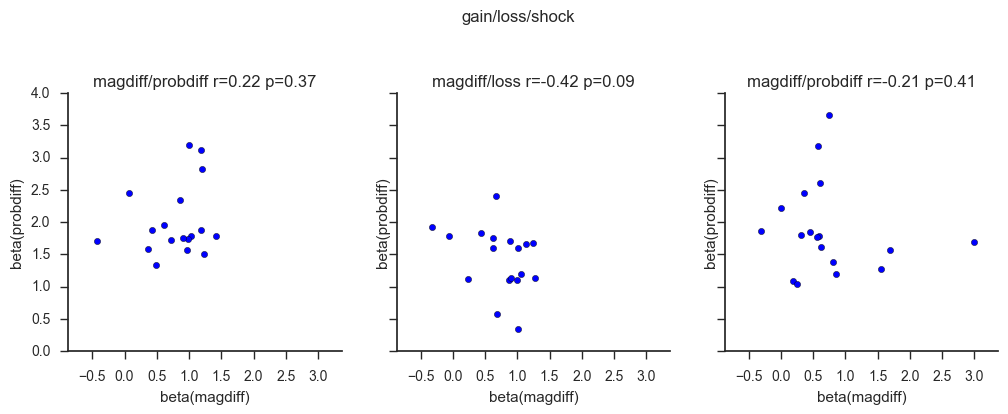

In [109]:
plotTriplet(gain, loss, shock)

# Statistics

## prepare dataframe

In [ ]:
model_param_df['condition'] = model_param_df['split']
model_param_df = model_param_df.rename(columns={"split": "task"})
model_param_df.task = model_param_df.task.str.replace('ambig_', '')
model_param_df.task = model_param_df.task.str.replace('un', '')
model_param_df.condition = model_param_df.condition.str.replace('_gain', 'uous')
model_param_df.condition = model_param_df.condition.str.replace('_loss', 'uous')
model_param_df.condition = model_param_df.condition.str.replace('_shock', 'uous')
model_param_df.head()

## define function for graphs

In [ ]:
def plot_params(df,stripplot=False,outlier_cutoff=None, suptitle='Model Parameters', ylabel='beta', xlabel='parameter', order=['ambig_gain', 'ambig_loss', 'ambig_shock'], colors = ['blue', 'red', 'green'], widtherr = 0.3):
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    matplotlib.rc("font", family="Times New Roman")
    sns.set_context('talk')
    sns.set_style('white',{'figure.facecolor':'white'})


    if outlier_cutoff is not None:
        df = df[(df.beta>-1.0*outlier_cutoff)&(df.beta<outlier_cutoff)]

    axis = sns.barplot(x='task',y='beta',hue='condition', hue_order=order, errwidth=widtherr, palette = colors, data=df,ci=68,alpha=0.4)

    if stripplot:
        sns.stripplot(x="task", y="beta",hue='condition', data=df,alpha=0.2,jitter=True);

    current_palette=sns.color_palette()
    fig = plt.gcf()
    fig.suptitle(suptitle,fontsize=12,x=0.55)
    sns.despine(ax=axis)
    axis.set_ylabel(ylabel,fontsize=12)
    axis.set_xlabel(xlabel,fontsize=12)
    #axis.set_xticklabels(df.parameter.unique(),rotation=45,fontsize=12,ha='right')
    #axis = plt.gca()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


    # change name if needed
    #xlabels = axis.get_xticklabels()

    #fig.suptitle('')
    #axis.set_title('Model Parameters (Across all Subjects)')
    #axis.set_xlabel('Parameter')
    #axis.set_ylabel('Group Regression Coefficients \n (Probability Choosing Ambig)')
    #plt.tight_layout()
    return(fig)

## Group Ambiguity Differences Across Tasks

### Task differences in ambiguity level 

In [ ]:
model_df = model_param_df.loc[model_param_df['parameter'] == 'ambiguityLevel']
fig = plot_params(model_df,stripplot=False,outlier_cutoff=None, suptitle='Ambiguity Level', ylabel='beta (chose ambiguous urn)', xlabel='task', order=['ambiguous'], colors = ['blue'], widtherr = 1.3)


#### Gain as reference

In [ ]:
#df.gain_or_loss_trial.astype('category')
y,X = dmatrices('beta ~ task', data = model_df, return_type='dataframe')
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

#### Loss as reference

In [ ]:
#tweak X, so that loss is the reference category instead of gain
X['task[T.gain]'] = 0
X.loc[(X['task[T.shock]'] == 0) & (X['task[T.loss]'] == 0), 'task[T.gain]'] = 1.0
X = X.drop('task[T.loss]', axis=1)

In [ ]:
#run releveled model
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

#### shock as reference

In [ ]:
#tweak X, so that shock is the reference category instead of gain
X['task[T.loss]'] = 0
X.loc[(X['task[T.shock]'] == 0) & (X['task[T.gain]'] == 0), 'task[T.loss]'] = 1.0
X = X.drop('task[T.shock]', axis=1)

In [ ]:
#run releveled model
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

### Task differences in ambiguity presence


#### Gain as reference

In [ ]:
model_df = model_param_df.loc[model_param_df['parameter'] == 'intercept']
fig = plot_params(model_df,stripplot=False,outlier_cutoff=None, suptitle='Intercept', ylabel='beta (chose ambiguous/right urn)', xlabel='task', order=['ambiguous', 'unambiguous'], colors = ['blue', 'orange'], widtherr = 1.3)


In [ ]:
#df.gain_or_loss_trial.astype('category')
y,X = dmatrices('beta ~ task + condition + task*condition', data = model_df, return_type='dataframe')
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

#### Loss as reference

In [ ]:
#relevel with loss as reference
X['task[T.gain]'] = 0
X.loc[(X['task[T.shock]'] == 0) & (X['task[T.loss]'] == 0), 'task[T.gain]'] = 1.0
X = X.drop('task[T.loss]', axis=1)
X = X.drop('task[T.loss]:condition[T.unambiguous]', axis = 1)

X['task[T.gain]:condition[T.unambiguous]'] = 0
X.loc[(X['task[T.gain]'] == 1) & (X['condition[T.unambiguous]'] == 1), 'task[T.gain]:condition[T.unambiguous]'] = 1.0


In [ ]:
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

#### shock as reference

In [ ]:
#relevel with shock as reference
X['task[T.loss]'] = 0
X.loc[(X['task[T.shock]'] == 0) & (X['task[T.gain]'] == 0), 'task[T.loss]'] = 1.0
X = X.drop('task[T.shock]', axis=1)
X = X.drop('task[T.shock]:condition[T.unambiguous]', axis = 1)

X['task[T.loss]:condition[T.unambiguous]'] = 0
X.loc[(X['task[T.loss]'] == 1) & (X['condition[T.unambiguous]'] == 1), 'task[T.loss]:condition[T.unambiguous]'] = 1.0


In [ ]:
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

## Risk Preference Differences Across Tasks

### Magnitude

In [ ]:
model_df = model_param_df
model_df = model_param_df.loc[model_param_df['parameter'] == 'mag_diff']
fig = plot_params(model_df,stripplot=False,outlier_cutoff=None, suptitle='Magnitude', ylabel='beta (chose ambiguous/right urn)', xlabel='task', order=['ambiguous', 'unambiguous'], colors = ['blue', 'orange'], widtherr = 1.3)


#### Gain as reference

In [ ]:
#df.gain_or_loss_trial.astype('category')
y,X = dmatrices('beta ~ task + condition + task*condition ', data = model_df, return_type='dataframe')
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

#### Loss as reference

In [ ]:
#relevel with loss as reference
X['task[T.gain]'] = 0
X.loc[(X['task[T.shock]'] == 0) & (X['task[T.loss]'] == 0), 'task[T.gain]'] = 1.0
X = X.drop('task[T.loss]', axis=1)
X = X.drop('task[T.loss]:condition[T.unambiguous]', axis = 1)

X['task[T.gain]:condition[T.unambiguous]'] = 0
X.loc[(X['task[T.gain]'] == 1) & (X['condition[T.unambiguous]'] == 1), 'task[T.gain]:condition[T.unambiguous]'] = 1.0


In [ ]:

model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

#### Shock as Reference

In [ ]:
#relevel with shock as reference
X['task[T.loss]'] = 0
X.loc[(X['task[T.shock]'] == 0) & (X['task[T.gain]'] == 0), 'task[T.loss]'] = 1.0
X = X.drop('task[T.shock]', axis=1)
X = X.drop('task[T.shock]:condition[T.unambiguous]', axis = 1)

X['task[T.loss]:condition[T.unambiguous]'] = 0
X.loc[(X['task[T.loss]'] == 1) & (X['condition[T.unambiguous]'] == 1), 'task[T.loss]:condition[T.unambiguous]'] = 1.0


In [ ]:
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

### Probability

In [ ]:
model_df = model_param_df
model_df = model_param_df.loc[model_param_df['parameter'] == 'prob_diff']
fig = plot_params(model_df,stripplot=False,outlier_cutoff=None, suptitle='Probability', ylabel='beta (chose ambiguous/right urn)', xlabel='task', order=['ambiguous', 'unambiguous'], colors = ['blue', 'orange'], widtherr = 1.3)


#### Gain as Reference

In [ ]:
y,X = dmatrices('beta ~ task + condition + task*condition', data = model_df, return_type='dataframe')
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

#### Loss as Reference

In [ ]:
#relevel with loss as reference
X['task[T.gain]'] = 0
X.loc[(X['task[T.shock]'] == 0) & (X['task[T.loss]'] == 0), 'task[T.gain]'] = 1.0
X = X.drop('task[T.loss]', axis=1)
X = X.drop('task[T.loss]:condition[T.unambiguous]', axis = 1)

X['task[T.gain]:condition[T.unambiguous]'] = 0
X.loc[(X['task[T.gain]'] == 1) & (X['condition[T.unambiguous]'] == 1), 'task[T.gain]:condition[T.unambiguous]'] = 1.0

In [ ]:
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

#### Shock as Reference

In [ ]:
#relevel with shock as reference
X['task[T.loss]'] = 0
X.loc[(X['task[T.shock]'] == 0) & (X['task[T.gain]'] == 0), 'task[T.loss]'] = 1.0
X = X.drop('task[T.shock]', axis=1)
X = X.drop('task[T.shock]:condition[T.unambiguous]', axis = 1)

X['task[T.loss]:condition[T.unambiguous]'] = 0
X.loc[(X['task[T.loss]'] == 1) & (X['condition[T.unambiguous]'] == 1), 'task[T.loss]:condition[T.unambiguous]'] = 1.0


In [ ]:
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

In [21]:
%%bash 
#jupyter nbconvert --to slides Clinical_DM_Learning_Rate_Difference_Anx_Dep.ipynb && mv Clinical_DM_Learning_Rate_Difference_Anx_Dep.slides.html Clinical_DM_Learning_Rate_Difference_Anx_Dep_v1.slides.html
#jupyter nbconvert --to html Example_analyze_emmas_fmri_shock_data.ipynb && mv Example_analyze_emmas_fmri_shock_data.html ../html_reports/Example_analyze_emmas_fmri_shock_data_v1.html
jupyter nbconvert --to pdf --template pdf_template_nocode.tplx Basic_Analyses.ipynb

cp Basic_Analyses.pdf ../reports/Basic_Analyses.pdf
cp Basic_Analyses.ipynb ../reports/Basic_Analyses.ipynb

[NbConvertApp] Converting notebook Basic_Analyses.ipynb to pdf
[NbConvertApp] Support files will be in Basic_Analyses_files/
[NbConvertApp] Making directory Basic_Analyses_files
[NbConvertApp] Making directory Basic_Analyses_files
[NbConvertApp] Making directory Basic_Analyses_files
[NbConvertApp] Making directory Basic_Analyses_files
[NbConvertApp] Making directory Basic_Analyses_files
[NbConvertApp] Making directory Basic_Analyses_files
[NbConvertApp] Making directory Basic_Analyses_files
[NbConvertApp] Making directory Basic_Analyses_files
[NbConvertApp] Making directory Basic_Analyses_files
[NbConvertApp] Making directory Basic_Analyses_files
[NbConvertApp] Making directory Basic_Analyses_files
[NbConvertApp] Making directory Basic_Analyses_files
[NbConvertApp] Making directory Basic_Analyses_files
[NbConvertApp] Making directory Basic_Analyses_files
[NbConvertApp] Making directory Basic_Analyses_files
[NbConvertApp] Making directory Basic_Analyses_files
[NbConvertApp] Making direc